Shape: (64764, 20)
Columnas: Index(['index', 'Provider ID', 'Hospital Name', 'Address', 'City', 'State',
       'ZIP Code', 'County Name', 'Phone Number', 'Measure Name', 'Measure ID',
       'Compared to National', 'Denominator', 'Score', 'Lower Estimate',
       'Higher Estimate', 'Footnote', 'Measure Start Date', 'Measure End Date',
       'Location'],
      dtype='object')
   index  Provider ID             Hospital Name                   Address  \
0      0       230100  TAWAS ST JOSEPH HOSPITAL               200 HEMLOCK   
1      1       230121       MEMORIAL HEALTHCARE      826 WEST KING STREET   
2      2       230118      HURON MEDICAL CENTER  1100 SOUTH VAN DYKE ROAD   
3      3       230121       MEMORIAL HEALTHCARE      826 WEST KING STREET   
4      4       230133  OTSEGO MEMORIAL HOSPITAL          825 N CENTER AVE   

         City State  ZIP Code County Name  Phone Number  \
0  TAWAS CITY    MI     48764       IOSCO    9893629301   
1      OWOSSO    MI     48867  SHIAWASS

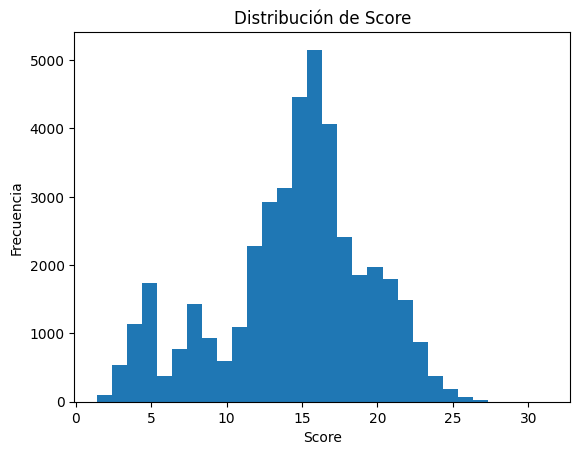

State
MP    18.500000
GU    16.536364
VI    15.957143
PR    15.854472
MS    15.345950
AR    15.323887
KY    15.227621
WV    15.142630
ND    15.024380
TN    14.967895
Name: Score, dtype: float64
Correlaciones con Score:
Score           1.000000
Phone Number   -0.000243
Provider ID    -0.001019
index          -0.011649
ZIP Code       -0.013909
Name: Score, dtype: float64
Varianza explicada total por PCA: 1.0000000000000002

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.42      0.41      0.42      5366
           1       0.57      0.58      0.57      7170

    accuracy                           0.51     12536
   macro avg       0.49      0.49      0.49     12536
weighted avg       0.51      0.51      0.51     12536

Matriz de confusión:
 [[2193 3173]
 [3005 4165]]


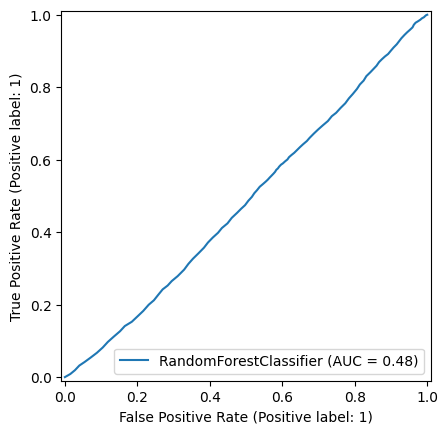

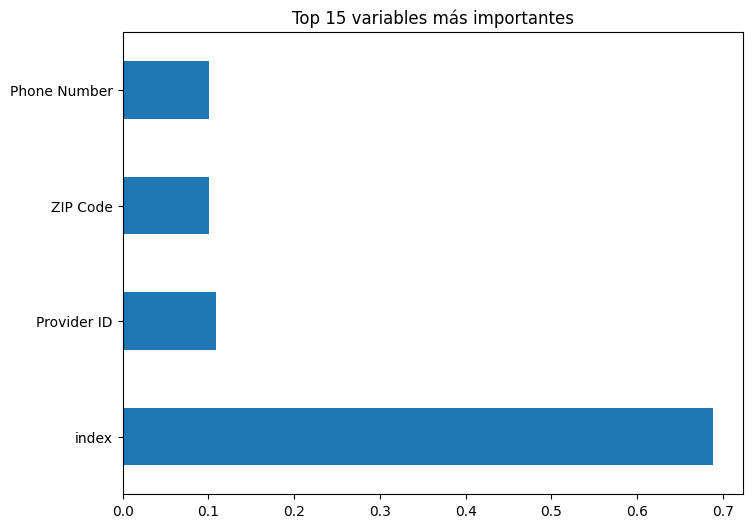

Distribución de hospitales por cluster:
Cluster
0    17245
2    13216
1    11324
Name: count, dtype: int64
Silhouette Score: 0.2277659326054085


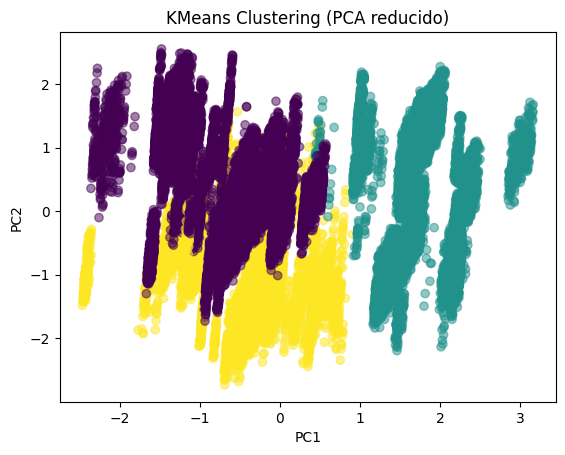

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# -----------------------------
# 1. Cargar dataset
# -----------------------------
fileCSV = "Readmissions_and_Deaths_-_Hospital.csv" 
df = pd.read_csv(fileCSV)
print("Shape:", df.shape)
print("Columnas:", df.columns)
print(df.head())

# -----------------------------
# 2. Exploración inicial (EDA)
# -----------------------------
print(df.info())
print(df.describe())

df['Score'] = pd.to_numeric(df['Score'], errors="coerce")
df = df.dropna(subset=["Score"])

# Histograma de la variable Score
plt.hist(df["Score"].dropna(), bins=30)
plt.title("Distribución de Score")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.show()

# Top estados por promedio de Score
print(df.groupby("State")["Score"].mean().sort_values(ascending=False).head(10))

# -----------------------------
# 3. Preprocesamiento
# -----------------------------
# Eliminar duplicados
df = df.drop_duplicates()

# Manejo de nulos
df = df.dropna(subset=["Score"])

# Codificación de variables categóricas
df_encoded = pd.get_dummies(df, columns=["Measure Name", "State"], drop_first=True)

# Escalado de variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.select_dtypes(include=np.number))

# -----------------------------
# 4. Selección de variables
# -----------------------------
numeric_df = df_encoded.select_dtypes(include=[np.number])  # solo numéricas
corr = numeric_df.corr()["Score"].sort_values(ascending=False)
print("Correlaciones con Score:")
print(corr.head(15))

# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada total por PCA:", pca.explained_variance_ratio_.sum())

# -----------------------------
# 5A. Modelado supervisado (clasificación)
# -----------------------------
# Crear target binaria: 1 si Score > promedio nacional, 0 en caso contrario
# -----------------------------
# 5A. Modelado supervisado (clasificación)
# -----------------------------
# Crear target binaria: 1 si Score > promedio nacional, 0 en caso contrario
y = np.where(df["Score"] > df["Score"].mean(), 1, 0)

# Usar solo columnas numéricas
X = df_encoded.drop(columns=["Score"]).select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

# Importancia de variables
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(15)
feat_imp.plot(kind="barh", figsize=(8,6))
plt.title("Top 15 variables más importantes")
plt.show()

# -----------------------------
# 5B. Modelado no supervisado (clustering)
# -----------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df["Cluster"] = clusters

print("Distribución de hospitales por cluster:")
print(df["Cluster"].value_counts())

print("Silhouette Score:", silhouette_score(X_scaled, clusters))

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clustering (PCA reducido)")
plt.show()